In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from utils_cells import get_images_list, transform_image, transform_target, resize_with_padding
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torchvision.transforms.functional as F
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import cv2
from sklearn.model_selection import train_test_split
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchmetrics import Precision, Recall
import numpy as np
import datetime
import random
import time
import torchvision.models as models

import random

class ImageDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None, reduce=False):
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = shuffle(self.load_dataset(data_path))

    def load_dataset(self, path):
        path = []
        classes = []
        for image_class in os.listdir('cells_final'):
            for img in os.listdir(f'cells_final/{image_class}'):
                path.append(f'cells_final/{image_class}/{img}')
                classes.append(image_class)

        dataset_final = pd.DataFrame()
        dataset_final['path'] = path
        dataset_final['class'] = classes
        return dataset_final                
                          
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = cv2.imread(f'{self.dataset["path"].loc[idx]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
        
        #image = resize_with_padding(image, (32, 32))
        image = image.astype(np.float32)
        image = image/255.0
        image = self.transform(image = image)['image'] if self.transform is not None else image

        target = self.dataset['class'].loc[idx]

        if target.strip() == 'normal':
            target_ = [1, 0, 0, 0]
        elif target.strip() == 'inflammatory':
            target_ = [0, 1, 0, 0]
        elif target.strip() == 'tumor':
            target_ = [0, 0, 1, 0]
        elif target.strip() == 'other':
            target_ = [0, 0, 0, 1]
        else:
            print(target)
        
        image = F.to_tensor(image)
        

        return image.float(), torch.Tensor(np.array(target_, dtype=np.float32))

/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
from einops import rearrange

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # [3, 32, 32] -> [32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                             # [32, 32, 32] -> [32, 16, 16]
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [32, 16, 16] -> [64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                             # [64, 16, 16] -> [64, 8, 8]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# [64, 8, 8] -> [128, 8, 8]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                             # [128, 8, 8] -> [128, 4, 4]
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# [128, 4, 4] -> [256, 4, 4]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                             # [256, 4, 4] -> [256, 2, 2]
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 256),                           # Latent space
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 256 * 2 * 2),                           # Expand back to match the flattened input size
            nn.Unflatten(dim=1, unflattened_size=(256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # [256, 2, 2] -> [128, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [128, 4, 4] -> [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # [64, 8, 8] -> [32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # [32, 16, 16] -> [3, 32, 32]
            nn.Sigmoid(),  # To ensure the output pixel values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Example usage


model = ConvAutoencoder()

# Sample input
x = torch.randn(1, 3, 32, 32)
reconstructed_img = model(x)

print(reconstructed_img.shape)  # Should output torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])


In [3]:
model = model.to('cuda')

In [4]:
import time
import torch
import wandb
from torch.utils.data import DataLoader
import numpy as np

# Initialize WandB
run_name = f'conv_autoencoder_training_{datetime.datetime.now()}'

# Configuration
batch_size = 32
learning_rate = 1e-4
num_epochs = 200
early_stop_patience = 15  # Number of epochs to wait for improvement
run_path = f'training_checkpoints/{run_name}'

# DataLoader
trainset = ImageDataset(data_path='train_data')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

# Model, loss function, optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}')
    time_start = time.perf_counter()
    model.train()
    
    epoch_loss = 0
    for batch_idx, (inputs, _) in enumerate(trainloader):
        inputs = inputs.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    print(f'Epoch {epoch} Average Loss: {avg_loss}')
    
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), f'{run_path}.pth')
        print(f'Saved new best model with loss {best_loss}')
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss}')
        break
    
    time_epoch = time.perf_counter() - time_start
    print(f'Epoch {epoch} time: {time_epoch/60} minutes')
    print('--------------------------------')

# Load the best model state dict
print(f'Loading model from {run_path}.pth')
model.load_state_dict(torch.load(f'{run_path}.pth'))

EPOCH: 0
Epoch 0 Average Loss: 0.00537726932205404
Saved new best model with loss 0.00537726932205404
Epoch 0 time: 0.24350317149999987 minutes
--------------------------------
EPOCH: 1
Epoch 1 Average Loss: 0.0019739149343151723
Saved new best model with loss 0.0019739149343151723
Epoch 1 time: 0.23748560968332033 minutes
--------------------------------
EPOCH: 2
Epoch 2 Average Loss: 0.0014503548536550128
Saved new best model with loss 0.0014503548536550128
Epoch 2 time: 0.24413543050000044 minutes
--------------------------------
EPOCH: 3
Epoch 3 Average Loss: 0.0011814751567840644
Saved new best model with loss 0.0011814751567840644
Epoch 3 time: 0.23997310224999638 minutes
--------------------------------
EPOCH: 4
Epoch 4 Average Loss: 0.001037029169411337
Saved new best model with loss 0.001037029169411337
Epoch 4 time: 0.25002781453332923 minutes
--------------------------------
EPOCH: 5
Epoch 5 Average Loss: 0.0009313755118604901
Saved new best model with loss 0.000931375511860

<All keys matched successfully>

In [6]:
model.load_state_dict(torch.load(f'training_checkpoints/conv_autoencoder_training_2024-07-29 23:42:57.372675.pth'))
features = []
classes = []
paths = []
model.eval()
trainset = ImageDataset(data_path='train_data')
torch.multiprocessing.set_sharing_strategy('file_system')
model = model.to('cuda')
with torch.no_grad():
    for idx in range(0, len(trainset)-1):
        img, cls = trainset[idx]
        classes.append(cls.cpu().detach().numpy())
        feature = model.encoder(img.to('cuda').reshape(1, 3, 32, 32))
        features.append(feature.cpu().detach().numpy())


    


In [7]:
cls = np.argmax(np.array(classes), axis=1)

In [8]:
len(features[1][0])

256

In [9]:
features = [feature[0] for feature in features]

In [10]:
arr = np.array(features)

In [11]:
df = pd.DataFrame()

In [12]:
from sklearn.manifold import TSNE
import numpy as np



# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(metric="euclidean", n_jobs=-1)

embs = tsne.fit_transform(np.array(arr))
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

In [13]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_embs = pca.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['pca_x'] = pca_embs[:, 0]
df['pca_y'] = pca_embs[:, 1]


In [14]:
import umap.umap_ as umap

# Perform UMAP
umap_reducer = umap.UMAP(n_components=2, metric="euclidean", n_jobs=-1)
umap_embs = umap_reducer.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['umap_x'] = umap_embs[:, 0]
df['umap_y'] = umap_embs[:, 1]


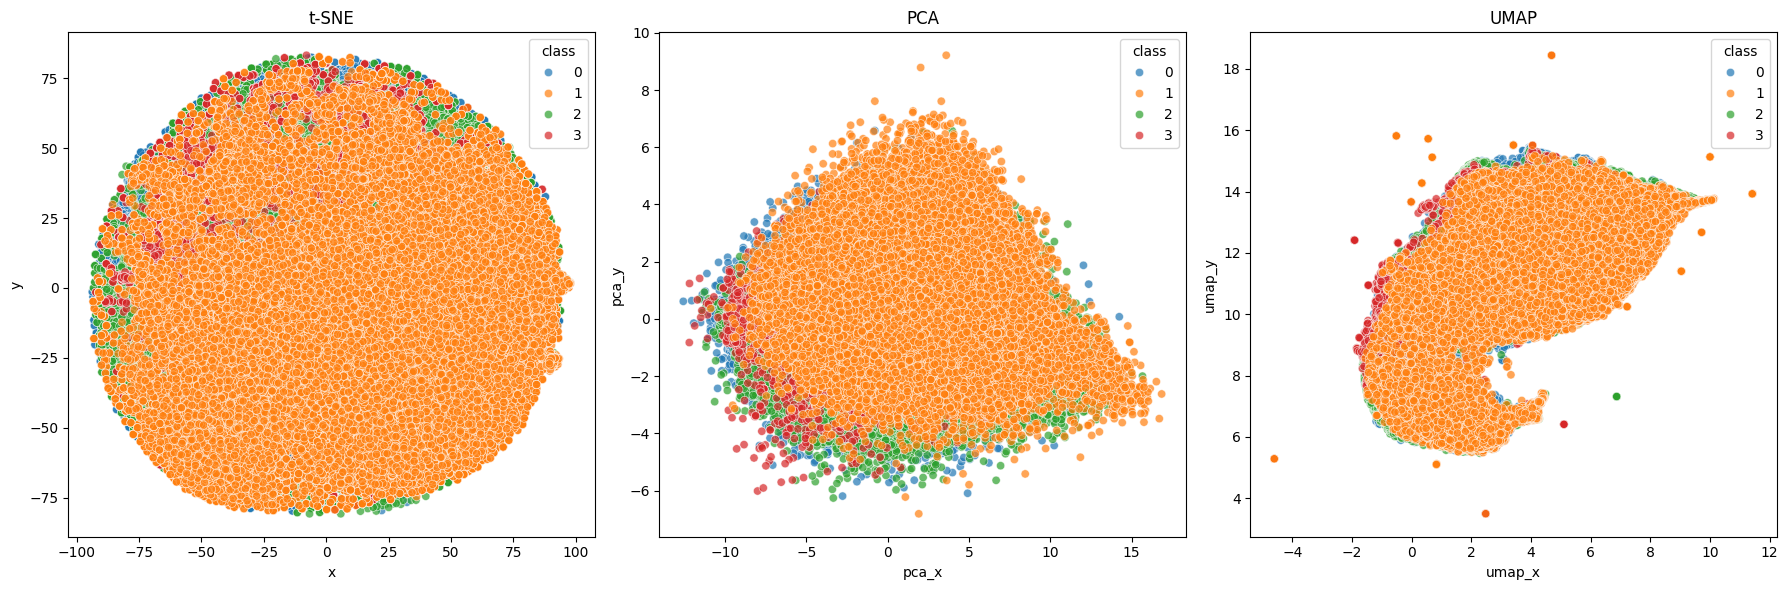

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
df['class'] = cls
# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=FS)

# t-SNE plot
sns.scatterplot(ax=axes[0], x='x', y='y', hue='class', data=df, palette='tab10', alpha=0.7)
axes[0].set_title('t-SNE')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# PCA plot
sns.scatterplot(ax=axes[1], x='pca_x', y='pca_y', hue='class', data=df, palette='tab10', alpha=0.7)
axes[1].set_title('PCA')
axes[1].set_xlabel('pca_x')
axes[1].set_ylabel('pca_y')

# UMAP plot
sns.scatterplot(ax=axes[2], x='umap_x', y='umap_y', hue='class', data=df, palette='tab10', alpha=0.7)
axes[2].set_title('UMAP')
axes[2].set_xlabel('umap_x')
axes[2].set_ylabel('umap_y')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


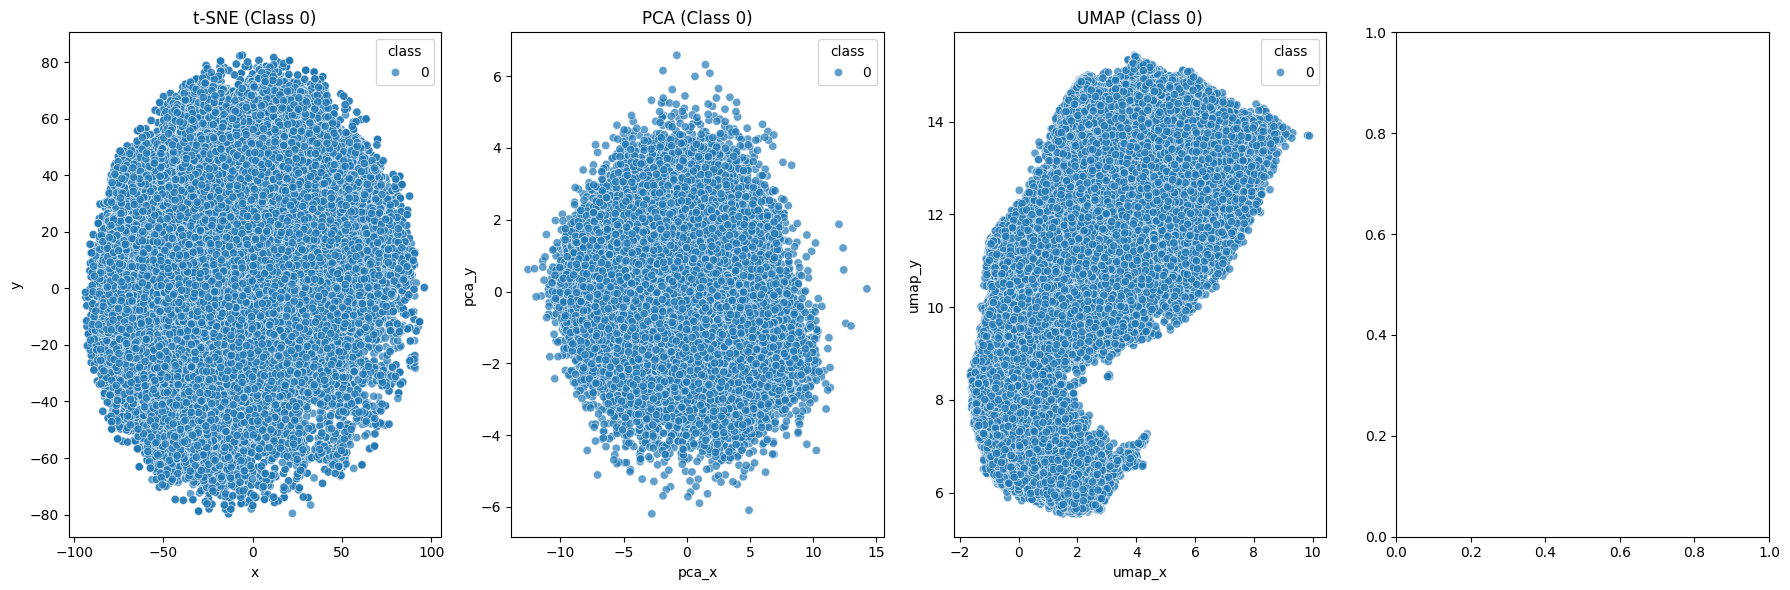

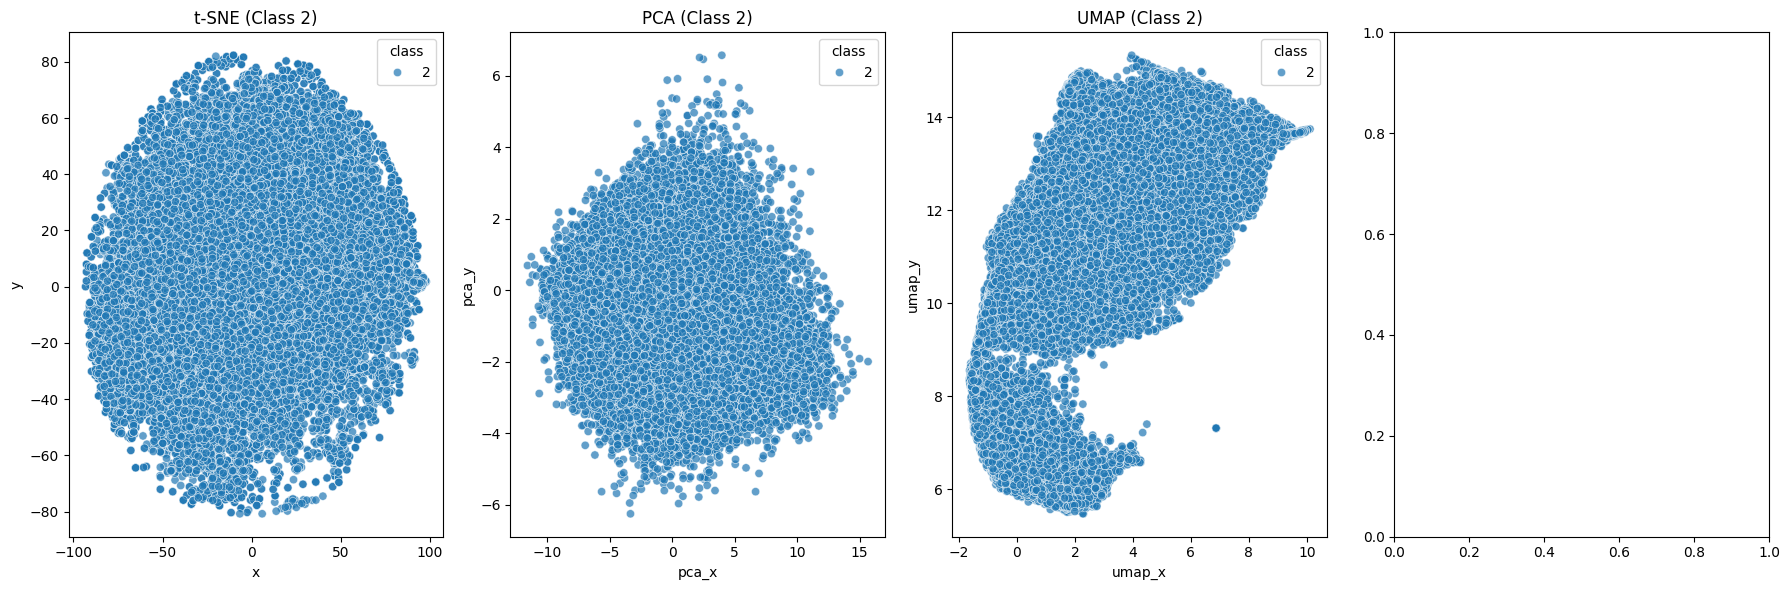

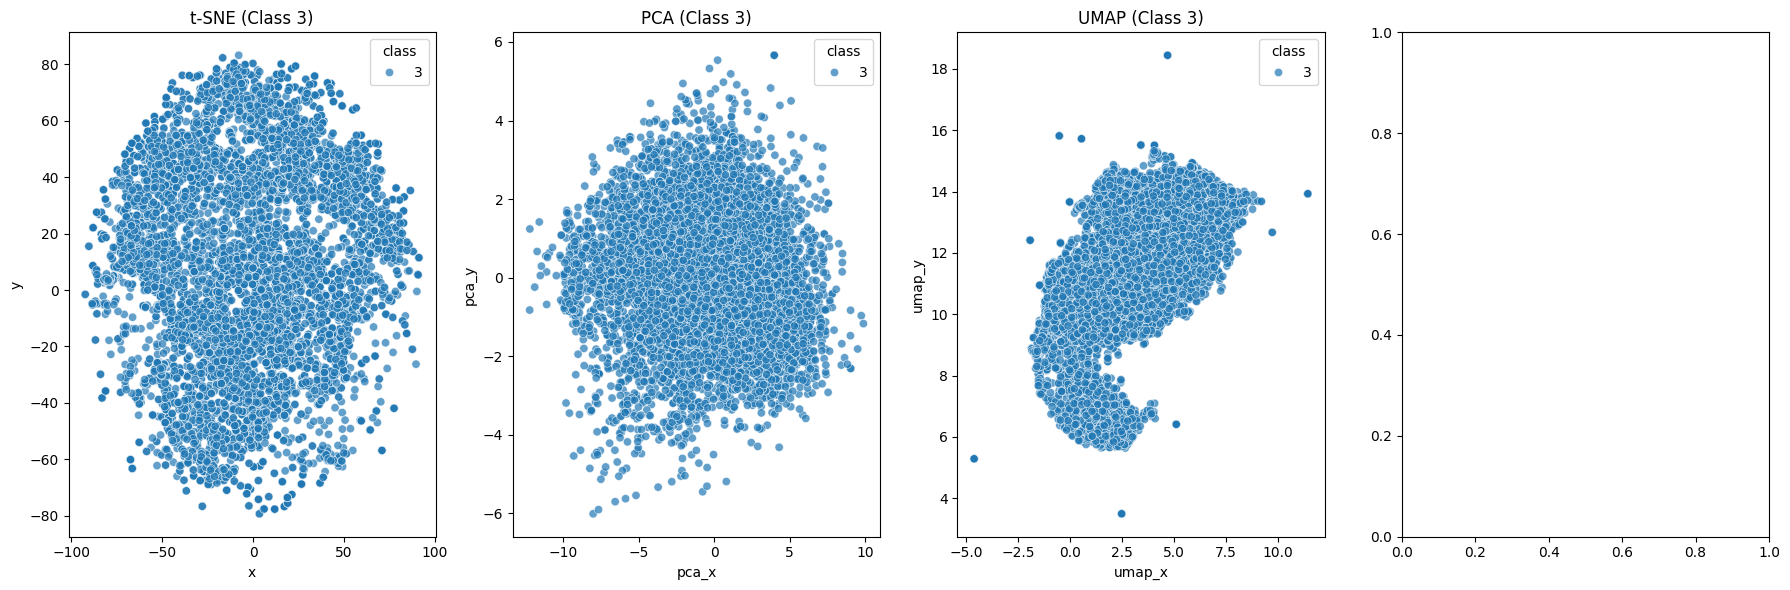

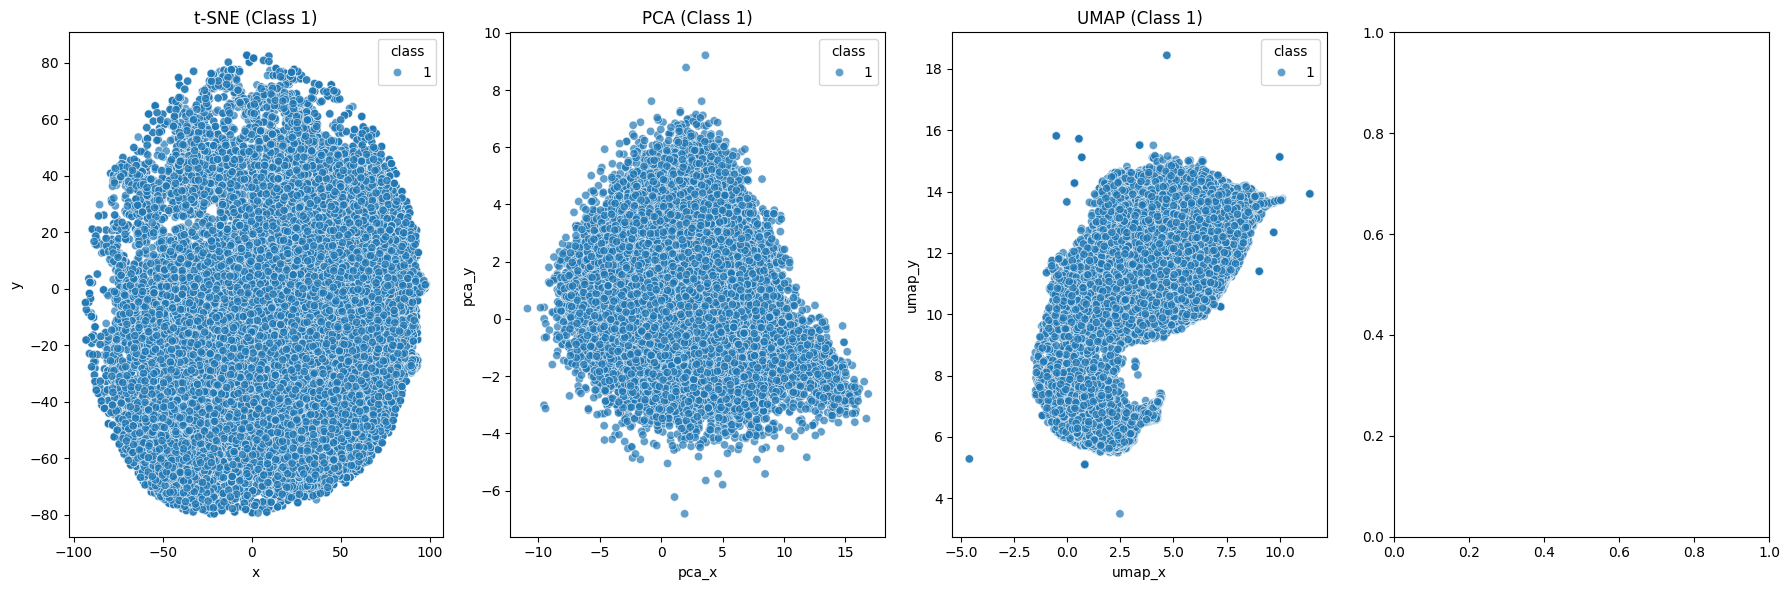

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df and cls are already defined
df['class'] = cls
FS = (18, 6)

# Get unique classes
unique_classes = df['class'].unique()

# Loop through each class and create a separate figure
for i, class_label in enumerate(unique_classes):
    # Filter the dataframe for the current class
    df_class = df[df['class'] == class_label]
    
    # Create a figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=FS)

    # t-SNE plot
    sns.scatterplot(ax=axes[0], x='x', y='y', hue='class', data=df_class, palette='tab10', alpha=0.7)
    axes[0].set_title(f't-SNE (Class {class_label})')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')

    # PCA plot
    sns.scatterplot(ax=axes[1], x='pca_x', y='pca_y', hue='class', data=df_class, palette='tab10', alpha=0.7)
    axes[1].set_title(f'PCA (Class {class_label})')
    axes[1].set_xlabel('pca_x')
    axes[1].set_ylabel('pca_y')

    # UMAP plot
    sns.scatterplot(ax=axes[2], x='umap_x', y='umap_y', hue='class', data=df_class, palette='tab10', alpha=0.7)
    axes[2].set_title(f'UMAP (Class {class_label})')
    axes[2].set_xlabel('umap_x')
    axes[2].set_ylabel('umap_y')

    # You can add a fourth plot here if needed

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
